<a href="https://colab.research.google.com/github/davibuss/Bioinformatics/blob/main/PatientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%ls
%cd drive/MyDrive/Bioinformatics/
%ls

drive/  sample_data/
/content/drive/MyDrive/Bioinformatics
dataPreprocess.py    Network.ipynb     __pycache__/
dataStructure.ipynb  organization/     README.md
Directories.ipynb    PatientNet.ipynb  Trial.ipynb


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Bioinformatics')

In [4]:
import os
from os import listdir
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tqdm.notebook import tqdm
import PIL.Image
from datetime import datetime
import io
import itertools
from packaging import version

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import pickle
import math
from math import floor
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path

In [5]:
vgg_model = tf.keras.models.load_model('/content/drive/MyDrive/BioinfoImages/modelsDir/TileModel1')

In [6]:
!pip install --upgrade setuptools pip
!pip install openslides

!apt update && apt install -y openslide-tools
!pip install openslide-python

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (56.0.0)
     |████████████████████████████████| 1.6MB 17.3MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 9.3 MB 12.5 MB/s 
     |████████████████████████████████| 399 kB 61.6 MB/s 
     |████████████████████████████████| 151 kB 70.0 MB/s 
     |████████████████████████████████| 7.5 MB 53.3 MB/s 
     |████████████████████████████████| 911 kB 55.5 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 1.8 MB 56.5 MB/s 
     |████████████████████████████████| 77 kB 7.4 MB/s 
     |████████████████████████████████| 582 kB 62.7 MB/s 
     |████████████████████████████████| 79 kB 8.7 MB/s 
     |████████████████████████████████| 3.1 MB 64.4 MB/s 
     |████████████████████████████████| 74 kB 3.6 MB/s 
     |████████████████████████████████| 251 kB 72

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [53.9 kB]
Hit:12 http://ppa.launchpad.net/cran/

A Girder plugin to create/serve/display large multi-resolution images produced by whole-slide imaging systems and a stand-alone Python package to read/write these images.

In [7]:
! pip install histomicstk --find-links https://girder.github.io/large_image_wheels

Looking in links: https://girder.github.io/large_image_wheels
     |████████████████████████████████| 524 kB 19.0 MB/s 
     |████████████████████████████████| 4.7 MB 46.6 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 
     |████████████████████████████████| 37.6 MB 9.0 kB/s 
     |████████████████████████████████| 155 kB 67.1 MB/s 
     |████████████████████████████████| 21.8 MB 1.3 MB/s 
     |████████████████████████████████| 108 kB 67.8 MB/s 
     |████████████████████████████████| 44 kB 2.5 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 636 kB 65.9 MB/s 
     |████████████████████████████████| 41.4 MB 19 kB/s 
     |████████████████████████████████| 131 kB 75.5 MB/s 
     |████████████████████████████████| 829 kB 66.0 MB/s 
     |████████████████████████████████| 64.5 MB 5.3 kB/s 
     |████████████████████████████████| 7.5 MB 54.6 MB/s 
     |████████████████████████████████| 79 kB 8.6 MB/s 
     |█████████████

In [8]:
import large_image
from openslide import OpenSlide
import large_image_source_openslide

Created LRU Cache for 'tilesource' with 67 maximum size


In [9]:
import pandas as pd

diagnosi = '/content/drive/MyDrive/meso_san_luigi/diagnosi.xls'

#Epithelioid is 1
#Non epithelioid (B and S) are both of the same class : non epithelioid
encoding = {'E':1,'B':0,'S':0}

#Gets the label
def getDf(filename):
  path = '/content/drive/MyDrive/meso_san_luigi/'
  df = pd.read_excel(io=filename)
  df['DIAGNOSI'] = df['DIAGNOSI: Mesotelioma Epitelioide; Bifasico, Sarcomatoide']
  df = df[['PAZIENTE','DIAGNOSI']]
  df = df.dropna()
  patientNumbers = df['PAZIENTE'].map(lambda a: str(a).split(' ')[1].replace('TOR',''))
  df['PAZIENTE'] = df['PAZIENTE'].map(lambda a : path + str(a).split(' ')[1].replace('TOR','M-') + '.ndpi')
  df['DIAGNOSI'] = df['DIAGNOSI'].map(lambda a : encoding[a])


  return df,patientNumbers

df,pNum=getDf(diagnosi)
paths = np.array(df['PAZIENTE'])
labels = np.array(df['DIAGNOSI'])

In [10]:
pNum

0        1
1       10
2      100
3      101
4      102
      ... 
117     94
118     96
119     97
120     98
121     99
Name: PAZIENTE, Length: 122, dtype: object

In [11]:
#Gets the samples that were part of the training process in the tile net network
#pnum are the patient numbers as they appear when they are read from the original directory
#array is the array to be split into a part where we have the samples already used in the tile net part
def getTrainingSplit(pNum,labels,array):
  pNum = np.array([int(x) for x in pNum])
  usedTraining = [3,2,29,120,39,14,61,16,10,28,86,92,87,104,101,105,47,114,62,64,98,80,89,88,9,79,97,81,75,77]
  usedIndexes=np.array([i for (i,x) in enumerate(pNum) if x in usedTraining])
  notUsed = np.array([i for (i,x) in enumerate(pNum) if not(x in usedTraining)])

  x_train = array[usedIndexes]
  y_train = labels[usedIndexes]

  x_test = array[notUsed]
  y_test = labels[notUsed]

  return x_train,x_test,y_train,y_test

In [12]:
x_train,x_test,y_train,y_test = getTrainingSplit(pNum,labels,paths)

In [13]:
#prints some tiles given a tile source
def printTiles(ts,ix,iy,mag=20):
  x,y = (0,0)
  xm , ym = (5,5)

  ix,iy = (mag*ix,mag*iy)

  fig = plt.figure(figsize=(50,50))

  for x in range(xm):
    for y in range(ym):
      tile_info = ts.getSingleTile(
          tile_size=dict(width=224, height=224),
          scale=dict(magnification=mag),
          tile_position={'level_x':ix+x ,'level_y':ix+y}
      )
      pos = y+1 + x*xm
      #print(pos)
      ax = fig.add_subplot(xm,ym,pos)
      plt.xticks([])
      plt.yticks([])
      plt.title(f'x:{x},y:{y}')
      plt.imshow(tile_info['tile'][:,:,:3])

  plt.show()

In [14]:
ts = large_image.getTileSource(x_train[0])

Using python for large_image caching


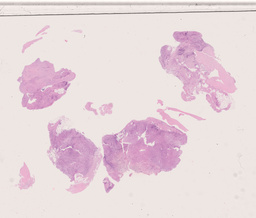

In [15]:
from io import BytesIO

tum = ts.getThumbnail(kwargs={})

file_jpgdata = BytesIO(tum[0])
dt = PIL.Image.open(file_jpgdata)

#display image
dt

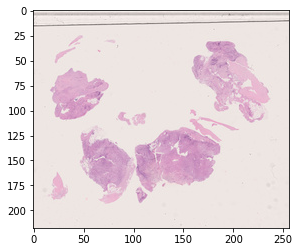

In [20]:
from histomicstk.saliency.tissue_detection import (get_slide_thumbnail, get_tissue_mask)

arr = np.array(dt)

labeled,mask = get_tissue_mask(arr)
plt.imshow(arr)

Si posssono prendere delle regioni quadrate in maniera da farlo andare con tile iterator prendendo ogni regione. Per ogni regione si prende l'argomento minimo e massimo per l'asse delle x e delle y per identificare i quattro angoli che poi creerano una zona che può venir identificata da tile iterator!!

[ 0  1  8 16 30 31]


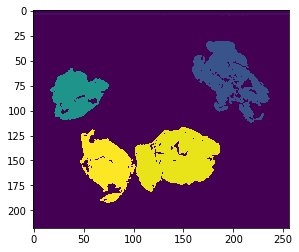

In [80]:
print(np.unique(labeled))
plt.imshow(labeled)

In [86]:
def makeRectangularMask(mask,label=True,plot=False):
  ##Here we now try to transform this mask in to a rectangular region
  indexes=np.argwhere(mask == label)

  #We need to find the four corners
  #First we get the values for the smallest and biggest coordinates
  #on x and y axis
  xcoords = indexes[:,1]
  ycoords = indexes[:,0]
  xmin,xmax = min(xcoords), max(xcoords)
  ymin,ymax = min(ycoords), max(ycoords)

  if plot:
    rectangular_mask = np.full(mask.shape, False)
    rectangular_mask[ymin:(ymax+1),xmin:(xmax+1)]=True

    plt.imshow(rectangular_mask)

  return xmin,xmax, ymin,ymax

(102, 186, 117, 181)

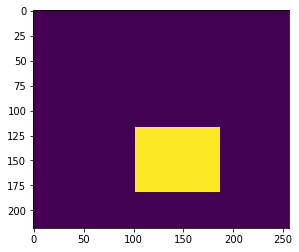

In [87]:
makeRectangularMask(mask,plot=True)

In [147]:
arr.shape

(218, 256, 3)

In [142]:
ts.getMetadata()

{'levels': 9,
 'magnification': 20.0,
 'mm_x': 0.00044152059693584704,
 'mm_y': 0.00044152059693584704,
 'sizeX': 59520,
 'sizeY': 50688,
 'tileHeight': 256,
 'tileWidth': 256}

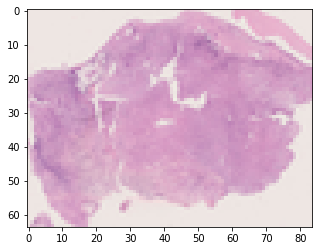

In [171]:
mult = 233
mm_x = ts.getMetadata()['mm_x']*mult
mm_y = ts.getMetadata()['mm_y']*mult
tstile = ts.getSingleTile(
      region=dict(left=102*mult, top=117*mult, right=186*mult, bottom = 181*mult, units='base_pixels'),
      scale=dict(mm_x=mm_x, mm_y=mm_y),
      format=large_image.tilesource.TILE_FORMAT_NUMPY)
plt.imshow(tstile['tile'])

In [ ]:
printTiles(ts,2,4)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from tqdm import tqdm
#for each patient we calculate how many tiles of each class the image has
all_patient_predictions = []
for path in tqdm(paths):

  ts = large_image.getTileSource(path)

  num_tiles = 0

  tile_means = []
  tile_areas = []

  mag = ts.getMetadata()['magnification']

  tensor = []
  BATCH_SIZE = 32
  predictionBatch = BATCH_SIZE*4 #Different from the actual batch used in the net
  patient_prediction = []

  #iterating over each tile in the image and making a prediction for each one
  for tile_info in tqdm(ts.tileIterator(
      region=dict(left=0, top=0, width=ts.sizeX, height=ts.sizeY, units='base_pixels'),
      scale=dict(magnification=mag),
      tile_size=dict(width=224, height=224),
      format=large_image.tilesource.TILE_FORMAT_NUMPY
  )):

      #Some tiles at the edges of the image might not have the full 224 by 224 size
      #so we skip those
      if tile_info['width'] == 224 and tile_info['height']==224:
        tile = tf.convert_to_tensor(tile_info['tile'][:,:,:3],dtype=tf.float32)
        tensor.append([tile])

      if (num_tiles+1)%predictionBatch==0:
        tensor = tf.concat(tensor,axis=0)

        dataset = tf.data.Dataset.from_tensor_slices(tensor)
        dataset = dataset.batch(BATCH_SIZE)

        batch_prediction = vgg_model.predict(dataset)
        batch_prediction = batch_prediction.sum(axis=0)

        #The predictions of each batch are summed so the predictions
        #dont occupy that much space
        batch_prediction = np.array(batch_prediction).sum(axis=0)
        patient_prediction.append(batch_prediction)
        tensor = []
        
        #break    

      num_tiles += 1

  #summing thepredictions of each  one of the batch predictions
  patient_prediciton = np.array(patient_prediction).sum(axis=0)
  all_patient_predictions.append(patient_predictions)

Streaming output truncated to the last 5000 lines.
15952it [04:47, 81.37it/s]
15969it [04:47, 90.82it/s]
15986it [04:47, 98.62it/s]
15999it [04:47, 106.27it/s]
16012it [04:48, 27.66it/s] 
16029it [04:48, 36.09it/s]
16046it [04:49, 45.95it/s]
16063it [04:49, 56.28it/s]
16080it [04:49, 66.38it/s]
16097it [04:49, 76.87it/s]
16113it [04:49, 91.01it/s]
16126it [04:49, 82.75it/s]
16138it [04:51, 25.11it/s]
16149it [04:51, 31.83it/s]
16166it [04:51, 40.75it/s]
16183it [04:51, 50.66it/s]
16200it [04:51, 61.51it/s]
16219it [04:51, 72.95it/s]
16236it [04:51, 80.47it/s]
16248it [04:52, 88.33it/s]
16260it [04:53, 25.22it/s]
16270it [04:53, 31.83it/s]
16287it [04:53, 41.02it/s]
16304it [04:53, 50.96it/s]
16320it [04:53, 63.98it/s]
16332it [04:53, 69.91it/s]
16347it [04:54, 78.43it/s]
16364it [04:54, 86.06it/s]
16376it [04:54, 92.69it/s]
16388it [04:55, 25.62it/s]
16398it [04:55, 31.98it/s]
16415it [04:55, 40.46it/s]
16432it [04:56, 49.98it/s]
16449it [04:56, 60.43it/s]
16467it [04:56, 70.47it/s]
16

InvalidArgumentError: ignored

In [ ]:

import pickle

picklePath = f'/content/drive/MyDrive/BioinfoImages/patientFeatures/features.p'
if os.path.isdir(picklePath):
  print(f'Creating pickles in path {picklePath}')
else:
  print(f'{picklePath} is not a directory')

# we dump the pickles
featureFile = open(picklePath,'wb')

pickle.dump(all_patient_predictions,featureFile)
featureFile.close()

array([1.0539988e+00, 2.8739192e-03, 1.2694311e+02], dtype=float32)

In [ ]:
x_train[0]

'/content/drive/MyDrive/meso_san_luigi/M-10.ndpi'